In [20]:
import numpy as np
import pandas as pd
import sklearn as sk
import copy
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.stats as ss
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

In [2]:
#read dataset
myDF=pd.read_table("Seismic bumps/seismic-bumps.txt",sep=",")
myDF.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180,48,-72,-72,a,0,0,0,0,0,0,0,0,0,0,0
1,a,a,N,14720,33,-70,-79,a,1,0,1,0,0,0,0,0,2000,2000,0
2,a,a,N,8050,30,-81,-78,a,0,0,0,0,0,0,0,0,0,0,0
3,a,a,N,28820,171,-23,40,a,1,0,1,0,0,0,0,0,3000,3000,0
4,a,a,N,12640,57,-63,-52,a,0,0,0,0,0,0,0,0,0,0,0


In [3]:
#check types
myDF.dtypes

seismic           object
seismoacoustic    object
shift             object
genergy            int64
gpuls              int64
gdenergy           int64
gdpuls             int64
ghazard           object
nbumps             int64
nbumps2            int64
nbumps3            int64
nbumps4            int64
nbumps5            int64
nbumps6            int64
nbumps7            int64
nbumps89           int64
energy             int64
maxenergy          int64
class              int64
dtype: object

In [4]:
#change label to category; get columns names by type numeric or not
myDF["class"]=myDF["class"].astype('category')
myDF_names_num=myDF.select_dtypes(include=np.number).columns
myDF_names_cat=myDF.select_dtypes(exclude=np.number).columns
myDF[myDF_names_cat]=myDF[myDF_names_cat].astype('category')
myDF.dtypes


seismic           category
seismoacoustic    category
shift             category
genergy              int64
gpuls                int64
gdenergy             int64
gdpuls               int64
ghazard           category
nbumps               int64
nbumps2              int64
nbumps3              int64
nbumps4              int64
nbumps5              int64
nbumps6              int64
nbumps7              int64
nbumps89             int64
energy               int64
maxenergy            int64
class             category
dtype: object

In [5]:
#summarize numeric variables
myDF[myDF_names_num].describe()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy
count,2.584000e+03,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.000000,2584.0,2584.0,2584.0,2584.000000,2584.000000
mean,9.024252e+04,538.579334,12.375774,4.508901,0.859520,0.393576,0.392802,0.067724,0.004644,0.0,0.0,0.0,4975.270898,4278.850619
std,2.292005e+05,562.652536,80.319051,63.166556,1.364616,0.783772,0.769710,0.279059,0.068001,0.0,0.0,0.0,20450.833222,19357.454882
min,1.000000e+02,2.000000,-96.000000,-96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
25%,1.166000e+04,190.000000,-37.000000,-36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
50%,2.548500e+04,379.000000,-6.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
75%,5.283250e+04,669.000000,38.000000,30.250000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,2600.000000,2000.000000
max,2.595650e+06,4518.000000,1245.000000,838.000000,9.000000,8.000000,7.000000,3.000000,1.000000,0.0,0.0,0.0,402000.000000,400000.000000


In [6]:
#summarize categorical variables
myDF[myDF_names_cat].describe()

,seismic,seismoacoustic,shift,ghazard,class
count,2584,2584,2584,2584,2584
unique,2,3,2,3,2
top,a,a,W,a,0
freq,1682,1580,1663,2342,2414


In [7]:
#remove useless columns
myDF=myDF.drop(columns=['nbumps6', 'nbumps7', 'nbumps89'],errors='ignore')
N=myDF.shape[0]
L=myDF.shape[1]
myDF_names_num=myDF.select_dtypes(include=np.number).columns
myDF.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy,class
0,a,a,N,15180,48,-72,-72,a,0,0,0,0,0,0,0,0
1,a,a,N,14720,33,-70,-79,a,1,0,1,0,0,2000,2000,0
2,a,a,N,8050,30,-81,-78,a,0,0,0,0,0,0,0,0
3,a,a,N,28820,171,-23,40,a,1,0,1,0,0,3000,3000,0
4,a,a,N,12640,57,-63,-52,a,0,0,0,0,0,0,0,0


In [9]:
#frequency tables for categorical variables
for col in myDF_names_cat:
    print(myDF[col].value_counts())

a    1682
b     902
Name: seismic, dtype: int64
a    1580
b     956
c      48
Name: seismoacoustic, dtype: int64
W    1663
N     921
Name: shift, dtype: int64
a    2342
b     212
c      30
Name: ghazard, dtype: int64
0    2414
1     170
Name: class, dtype: int64


In [10]:
#define cramers v measure
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
def cramers_v_row(c,m):
    return(np.asarray(m.apply(lambda x: cramers_v(x, c))))

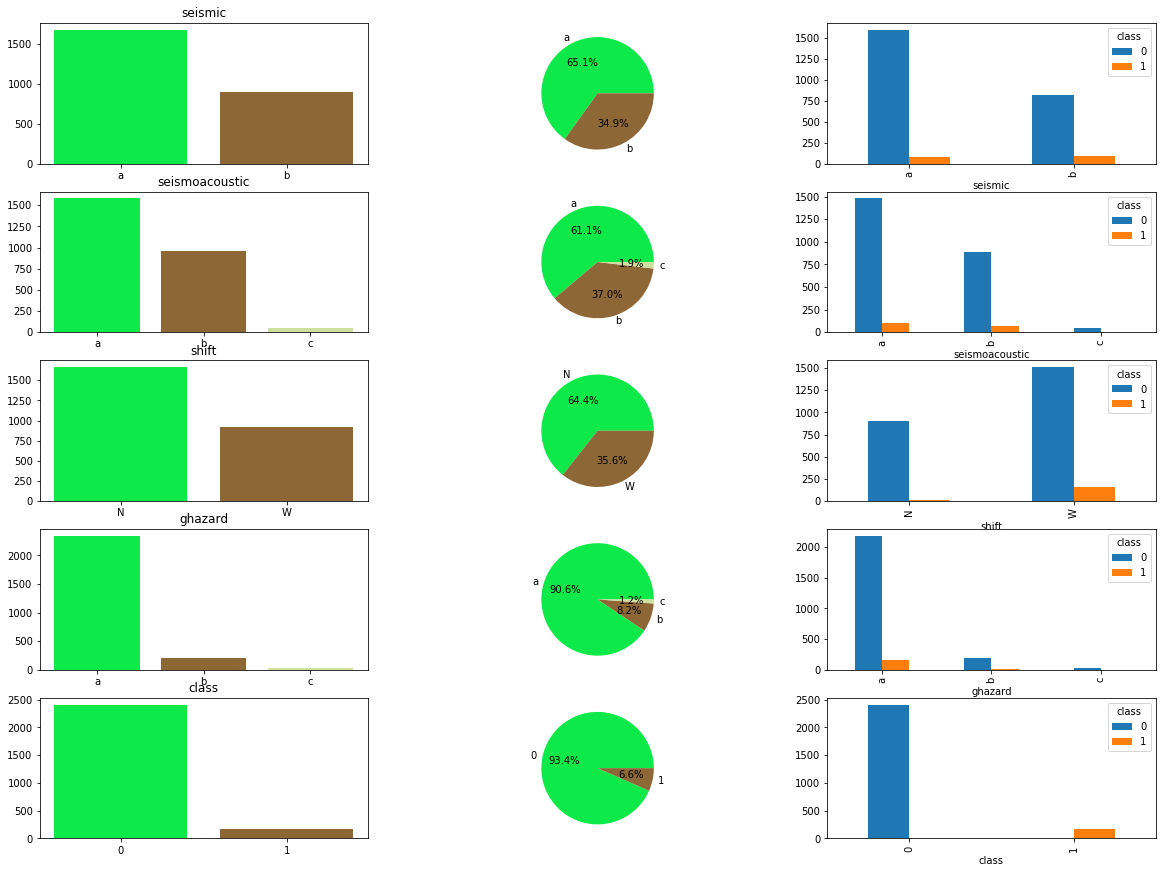

In [11]:
#plot frequency for categorical variables; determine cramers V matrix
myDF_n_cat=len(myDF_names_cat)
fig, axs = plt.subplots(myDF_n_cat,3,figsize=(20, 15))
bar_col = np.random.rand(20,3)
cramersV_matrix=pd.DataFrame(np.zeros((myDF_n_cat, myDF_n_cat)),columns=myDF_names_cat,index=myDF_names_cat)
for i in range(myDF_n_cat):
    col = myDF_names_cat[i]
    l=myDF[col].unique()
    n=myDF[col].nunique()
    x =  np.arange(n)
    y = myDF[col].value_counts()
    axs[i,0].bar(x,y,color=bar_col[0:n,:])
    axs[i,0].set_title(col)
    axs[i,0].set_xticks(x)
    axs[i,0].set_xticklabels(l)
    axs[i,1].pie(y,labels=l,autopct='%1.1f%%',colors=bar_col[0:n,:])
    pd.crosstab(index=myDF[col], columns=myDF["class"]).plot(kind="bar",ax= axs[i,2])
    cramersV_matrix[col]=cramers_v_row(myDF[col],myDF[myDF_names_cat])


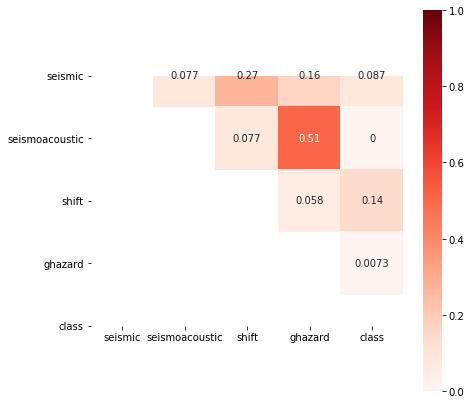

In [13]:
#plot cramers V matrix
mask = np.tril(np.ones_like(cramersV_matrix, dtype=np.bool))
f, ax = plt.subplots(figsize=(7, 7))
ax=sns.heatmap(cramersV_matrix, mask=mask, cmap="Reds", vmax=1,square=True,annot=True)

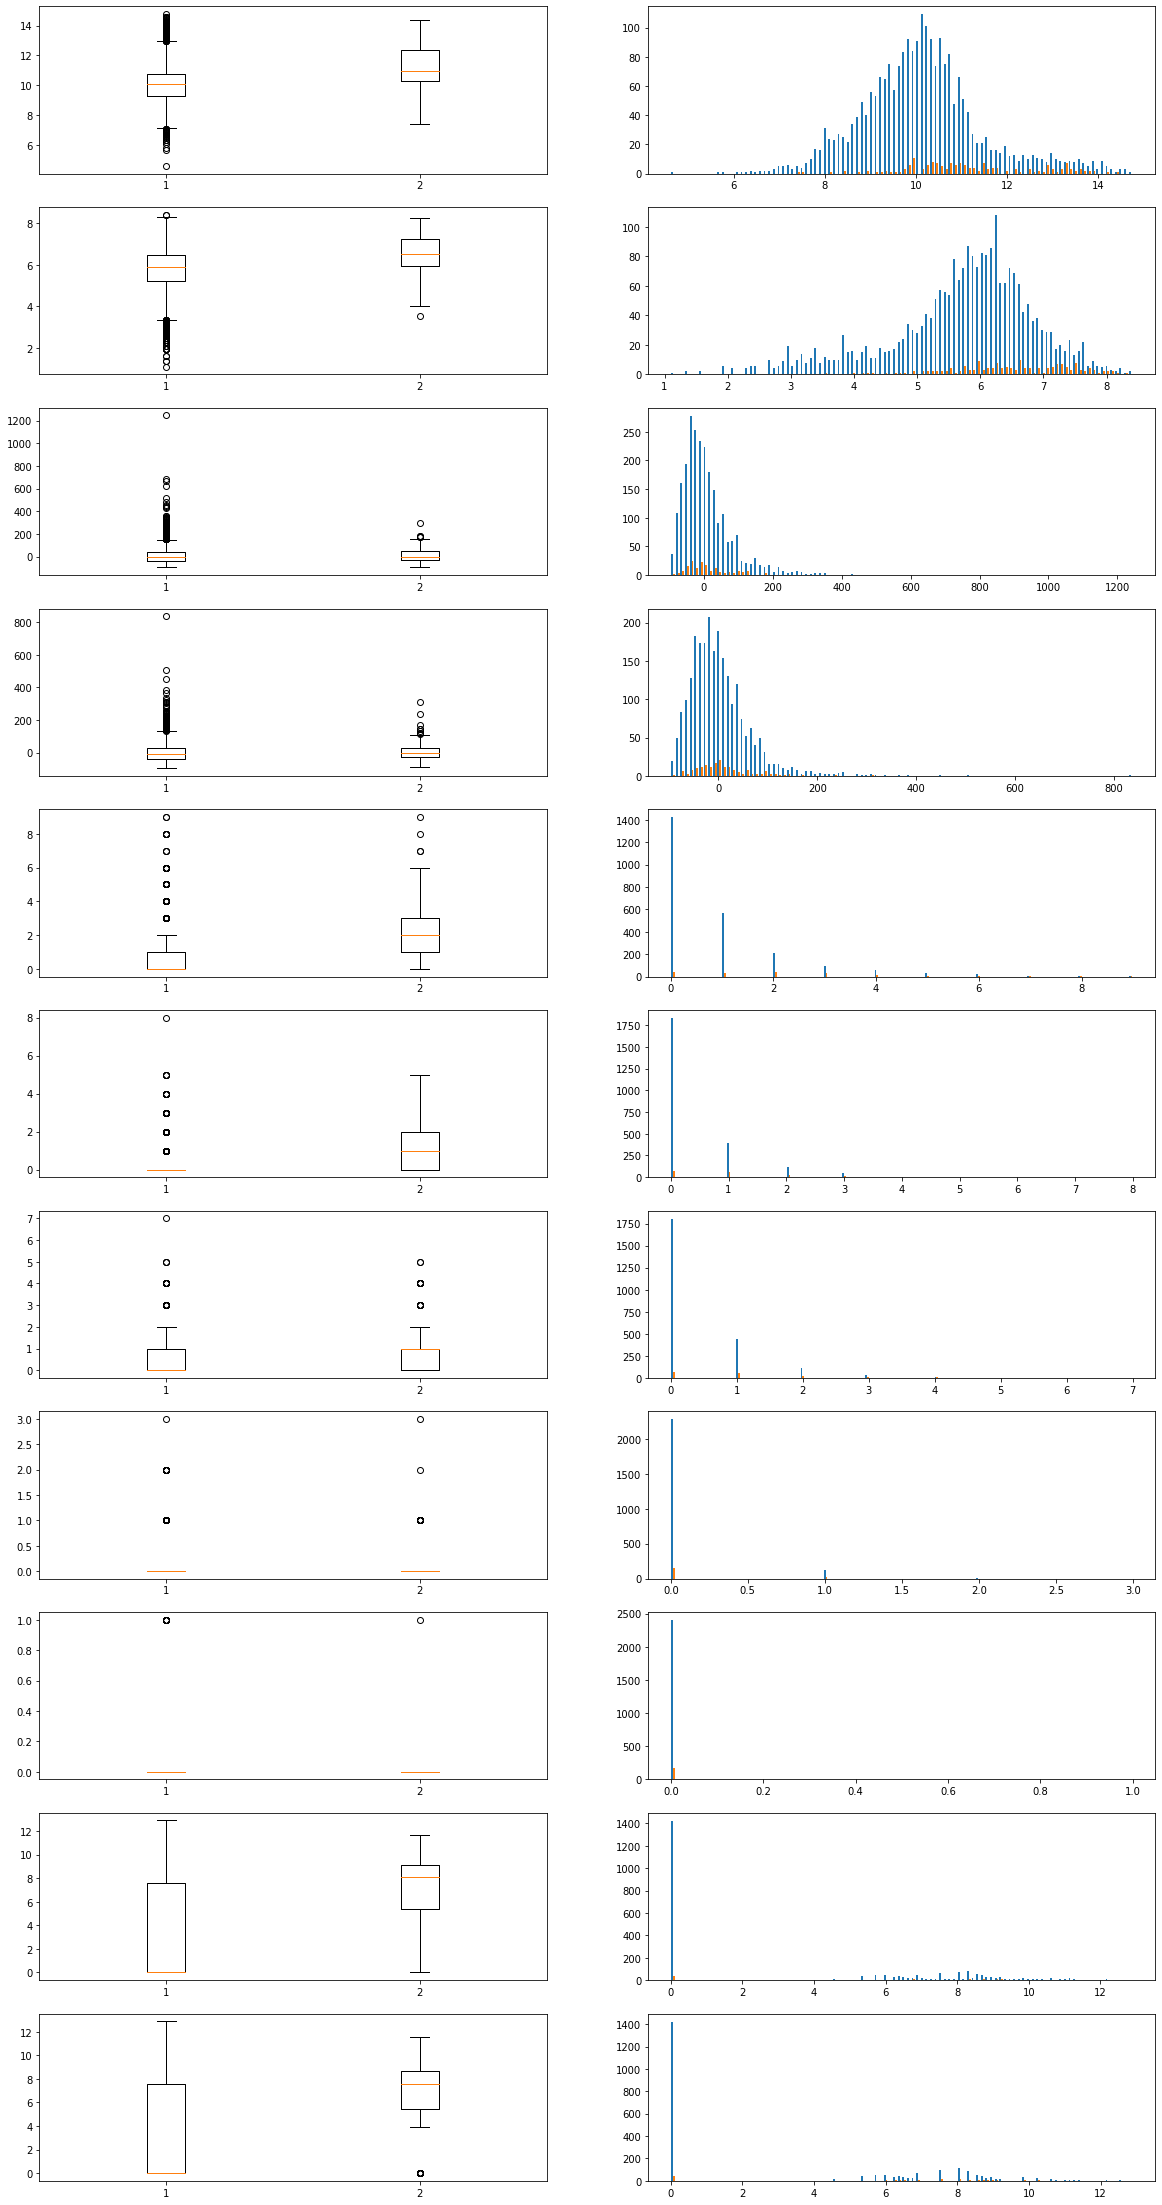

In [14]:
#plot boxplots and histograms for numeric variables
myDF_n_num = len(myDF_names_num)
fig, ax = plt.subplots(myDF_n_num,2,figsize=(20, 40))
for i in range(myDF_n_num):
    if max(myDF[myDF_names_num[i]])<2000:
        toplot =[myDF[myDF_names_num[i]][myDF['class']==0], myDF[myDF_names_num[i]][myDF['class']==1]]
    else:
        toplot  =[np.log(myDF[myDF_names_num[i]][myDF['class']==0]+1),np.log(myDF[myDF_names_num[i]][myDF['class']==1]+1)]
    ax[i,0].boxplot(toplot )
    ax[i,1].hist(toplot,100)


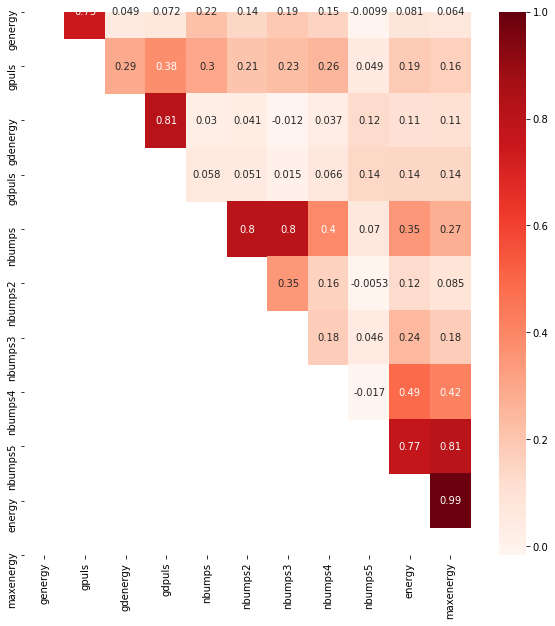

In [22]:
#plot correlation matrix for numeric variables
mask = np.tril(np.ones_like(myDF[myDF_names_num].corr(), dtype=np.bool))
f, ax = plt.subplots(figsize=(10, 10))
ax=sns.heatmap(myDF[myDF_names_num].corr(),cmap='Reds',mask=mask,annot=True)

In [17]:
#define function for normalization
def myscale(X):
    return(X*1.0/(X.max()- X.min()))

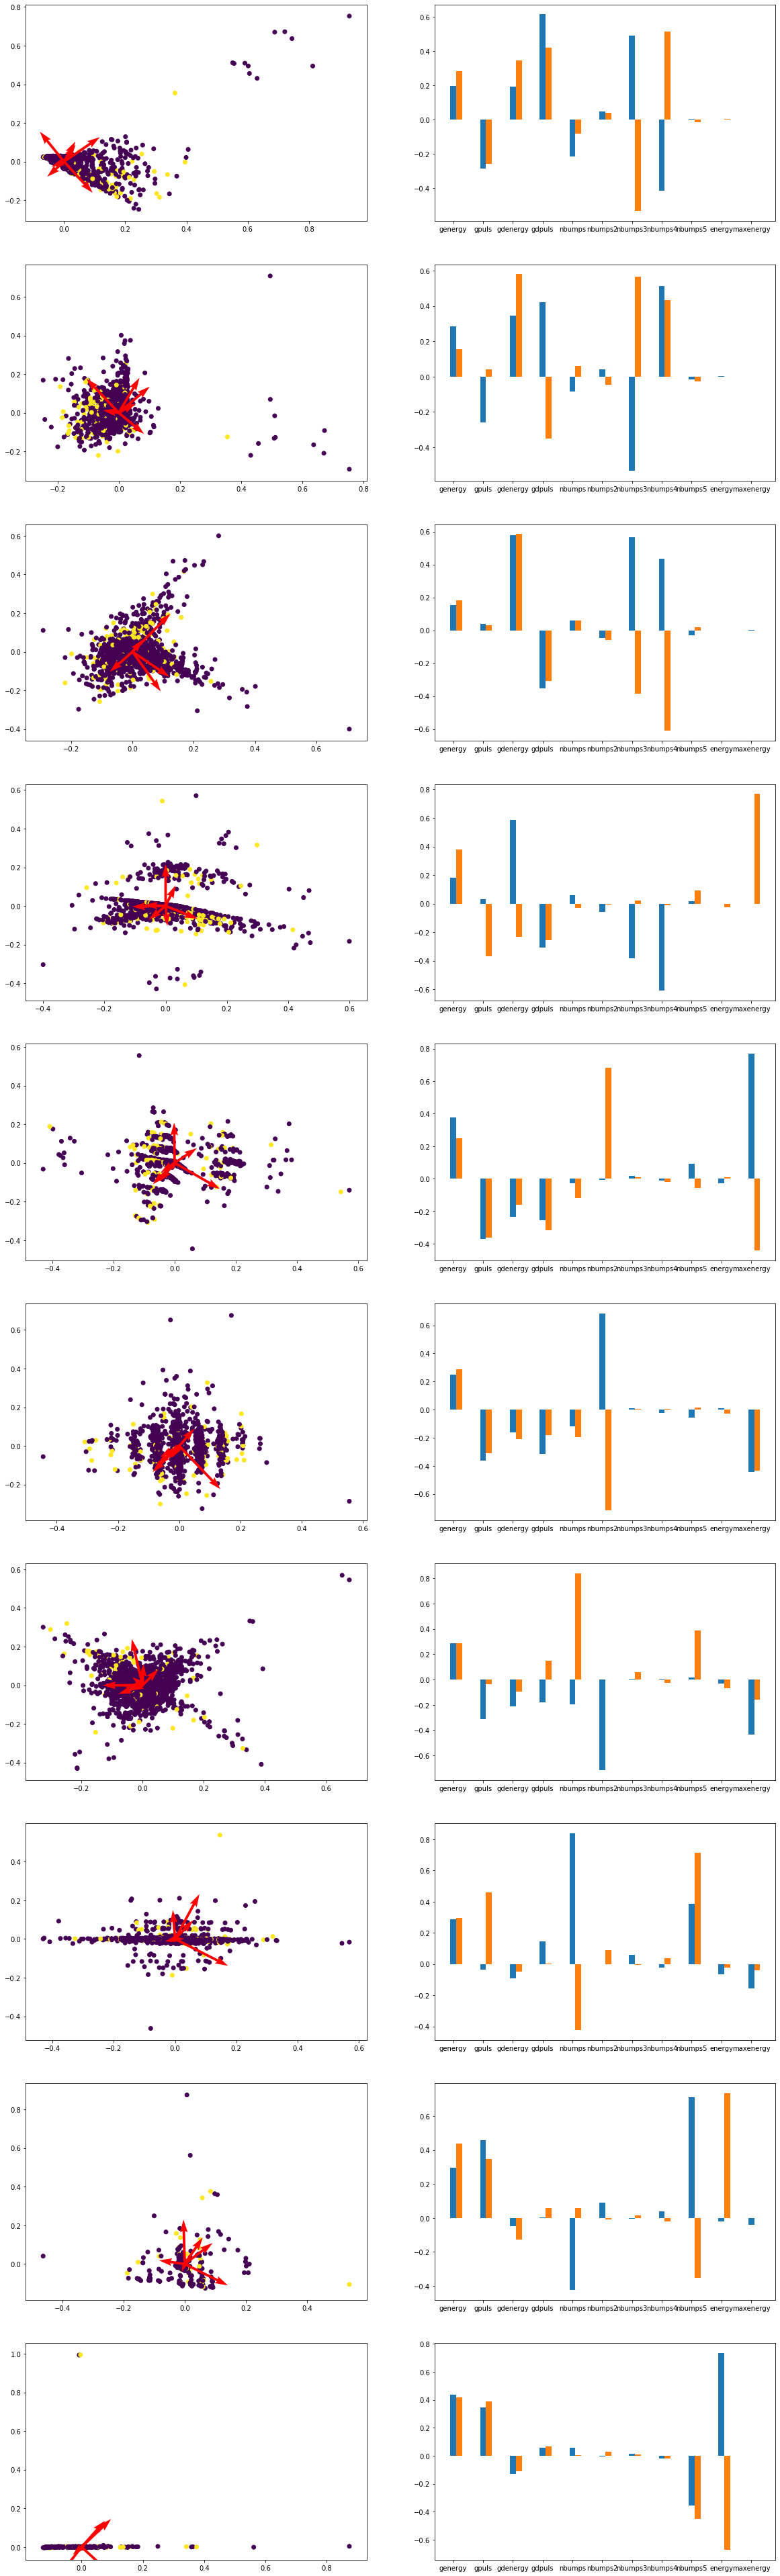

In [18]:
#determine PCA and plot biplots
myDF_norm=sk.preprocessing.scale(myDF[myDF_names_num])
pca = sk.decomposition.PCA()
scores=pca.fit_transform(myDF_norm)
pca.__dict__
fig, ax = plt.subplots(myDF_n_num-1,2,figsize=(20, 70))
for i in range(myDF_n_num-1):
    ax[i,0].scatter(myscale(scores[:,i]),myscale(scores[:,i+1]),c=myDF['class'])
    ax[i,0].quiver(0, 0, pca.components_[:,i], pca.components_[:,i+1],color='r',alpha=1)
    ax[i,1].bar(np.arange(myDF_n_num),pca.components_[:,i],width=0.2)
    ax[i,1].bar(np.arange(myDF_n_num)+.2,pca.components_[:,i+1],width=0.2)
    ax[i,1].set_xticks(np.arange(myDF_n_num))
    ax[i,1].set_xticklabels(myDF_names_num)

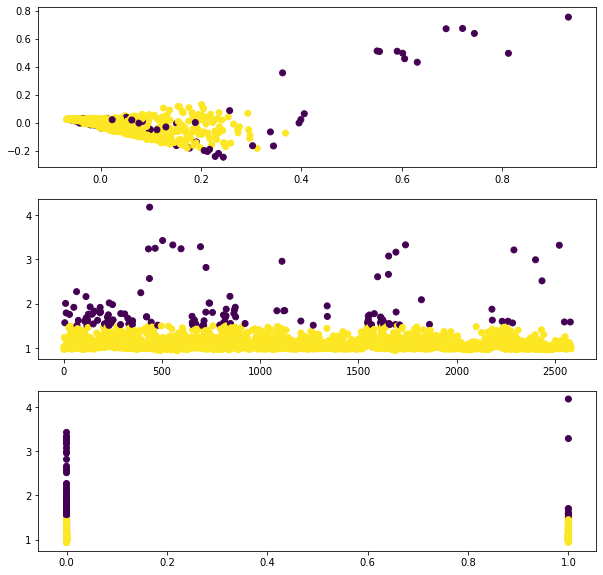

In [25]:
#determine and plot outliers
lof=LocalOutlierFactor()
lof.fit(myDF_norm)
lof.fit_predict(myDF_norm)
f, ax = plt.subplots(3,1,figsize=(10, 10))
ax[0].scatter(myscale(scores[:,0]),myscale(scores[:,1]),c=lof.fit_predict(myDF_norm))
ax[1].scatter(np.arange(N),-lof.negative_outlier_factor_,c=lof.fit_predict(myDF_norm))
ax[2].scatter(myDF['class'],-lof.negative_outlier_factor_,c=lof.fit_predict(myDF_norm))

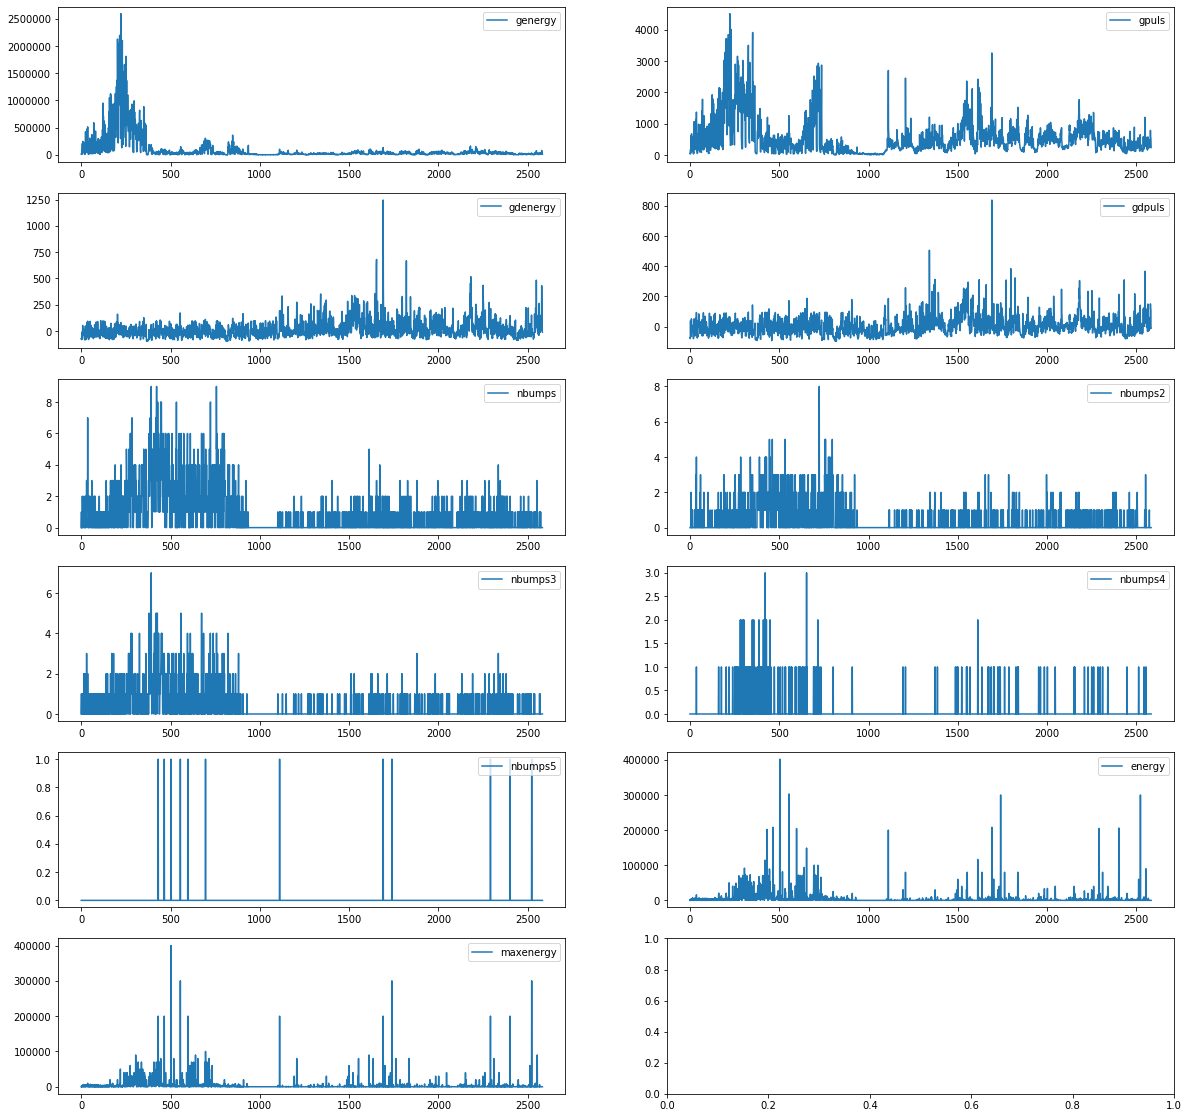

In [26]:
#plot numerical variables as time series
f, ax = plt.subplots((myDF_n_num+1)//2,2,figsize=(20, 20))
for i in range(myDF_n_num):
    col = myDF_names_num[i]
    ax[i//2,i%2].plot(np.arange(N),myDF[col],label=col)
    ax[i//2,i%2].legend(loc="upper right")

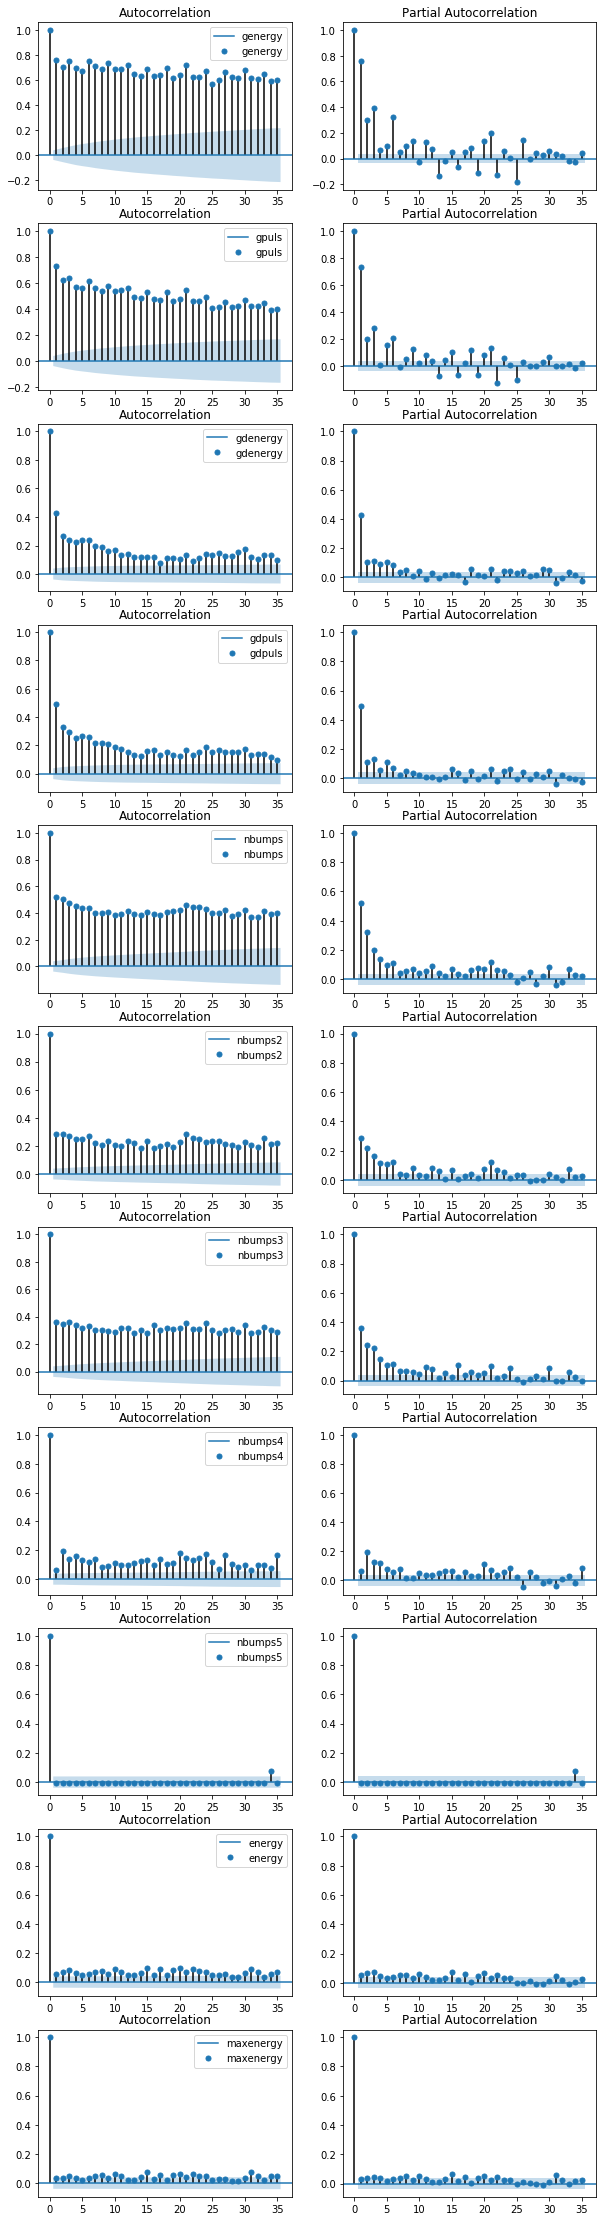

In [27]:
#plot acf and pacf for numerical variables
f, ax = plt.subplots(myDF_n_num,2,figsize=(10, 40))
for i in range(myDF_n_num):
    col = myDF_names_num[i]
    plot_acf(myDF[col],ax=ax[i,0],label=col)
    plot_pacf(myDF[col],ax=ax[i,1])
    ax[i,0].legend(loc="upper right")